# Síťová analýza: Vědecká korespondence v Británii 18.-19. století

V tomto notebooku si budeme prakticky osvojovat koncepty síťové analýzy. Z veřejně dostupných dat si vytvoříme několik síťových grafů, které budeme dále upravovat, analyzovat a vizualizovat.

Jedním z nejhodnotnějších typů historických dat jsou sbírky dopisů, které nám umožňují sledovat kdo, s kým a kdy udřžoval kontakty. Řada těchto dopisních sbírek byla v posledních dekádách digitalizována. Existují tak například digitalizované kolekce sbírkek dopisů středověkých žen (https://epistolae.ctl.columbia.edu/letters/) nebo rozsáhlá kolekce raně novověkých dopisů EMLO (=Early Modern Letters Online, http://emlo-portal.bodleian.ox.ac.uk/collections/?page_id=907#copyright). Některé tyto datasety umožňují přístup pouze pomocí prohlížeče, a tudíž se nehodí pro datově analytickou práci. Jiné jsou naopak vzorovými příklady datového kurátorství. Ty zde budeme používat.

Konkrétně využijeme dataset dopisů mezi britskými vědci konce 18. a celého 19. století **Ɛpsilon** ([web](https://epsilon.ac.uk)), vyvíjený týmem z *Cambridge University Digital Library*. 
> Ɛpsilon opens up new research opportunities in the history of 19th century science by bringing correspondence data and transcriptions from multiple sources into a single cross-searchable digital platform. It currently holds details of over 50,000 letters and is growing. 

Alespoň z pohledu datové analýzy je velkou devízou tohoto projektu fakt, že veškerá data jsou dostupná nejen pro potřeby prohledávání a pročítání na webu projektu, ale také ve velice úhledné a praktické formě dostupná na GitHubu ([zde](https://github.com/cambridge-collection/epsilon-data)). Nachází se zde jak digitální edice každého jednotlivého dopisu podle standardu TEI-XML, tak i tabulky metadat ve formátu CSV. S těmi budeme níže pracovat my, když se je přímo z GitHubu načteme do našeho výpočetního prostředí. 

Nejprve budeme pracovat s kolekcí dopisů *Londínské Linneovské společnosti*, která byla založena roku 1788 a existuje dodnes  ([wikipedia](https://en.wikipedia.org/wiki/Linnean_Society_of_London)). Ač nese jméno významného švédského vědce Carla Linného ([wikipedia](https://cs.wikipedia.org/wiki/Carl_Linné)), otce vědecké taxonomie, tato vědecká společnost vznikla v Anglii až po jeho smrti.  

Tabulková data budeme zpracovávat pomocí knihovny **pandas**. K síťové analýze využijeme knihovnu **networkX**, jejíž dokumentaci doporučuji k projití si - [zde](https://networkx.org/documentation/stable/index.html)).

## Korespondence Linnevské společnosti

### Extrakce a přehled dat

In [116]:
import numpy as np
import pandas as pd
import requests
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import regex

In [2]:
# navštívíme url adresu, kde jsou umístěny všechny csv soubory
# načteme HTTP odpověď do JSON formátu (není možné vždy, ale zde to funguje
resp_json = requests.get("https://github.com/cambridge-collection/epsilon-data/tree/main/csv").json()

Nyní si vypíšeme obsah načtených dat a zorientujeme v příslušné struktuře:

In [3]:
resp_json

{'payload': {'allShortcutsEnabled': False,
  'path': 'csv',
  'repo': {'id': 542535762,
   'defaultBranch': 'main',
   'name': 'epsilon-data',
   'ownerLogin': 'cambridge-collection',
   'currentUserCanPush': False,
   'isFork': False,
   'isEmpty': False,
   'createdAt': '2022-09-28T10:35:52.000Z',
   'ownerAvatar': 'https://avatars.githubusercontent.com/u/60095854?v=4',
   'public': True,
   'private': False,
   'isOrgOwned': True},
  'currentUser': None,
  'refInfo': {'name': 'main',
   'listCacheKey': 'v0:1664380801.622886',
   'canEdit': False,
   'refType': 'branch',
   'currentOid': 'a67ad584aa6afd616b88ef73e41c1d9d487591c1'},
  'tree': {'items': [{'name': 'ampere.csv',
     'path': 'csv/ampere.csv',
     'contentType': 'file'},
    {'name': 'darwin-correspondence.csv',
     'path': 'csv/darwin-correspondence.csv',
     'contentType': 'file'},
    {'name': 'darwin-family-letters.csv',
     'path': 'csv/darwin-family-letters.csv',
     'contentType': 'file'},
    {'name': 'farada

Vidíme, že ve struktuře je možné nalézt výpis jednotlivých `csv` souborů, které nás zajímají - nacházejí se pod tagem `"tree"`, ten je však zanořen v dalších tagách.

In [4]:
resp_json["payload"]["tree"]["items"]

[{'name': 'ampere.csv', 'path': 'csv/ampere.csv', 'contentType': 'file'},
 {'name': 'darwin-correspondence.csv',
  'path': 'csv/darwin-correspondence.csv',
  'contentType': 'file'},
 {'name': 'darwin-family-letters.csv',
  'path': 'csv/darwin-family-letters.csv',
  'contentType': 'file'},
 {'name': 'faraday.csv', 'path': 'csv/faraday.csv', 'contentType': 'file'},
 {'name': 'henslow.csv', 'path': 'csv/henslow.csv', 'contentType': 'file'},
 {'name': 'herschel.csv', 'path': 'csv/herschel.csv', 'contentType': 'file'},
 {'name': 'kemp.csv', 'path': 'csv/kemp.csv', 'contentType': 'file'},
 {'name': 'linnean-society.csv',
  'path': 'csv/linnean-society.csv',
  'contentType': 'file'},
 {'name': 'royal-society.csv',
  'path': 'csv/royal-society.csv',
  'contentType': 'file'},
 {'name': 'somerville.csv',
  'path': 'csv/somerville.csv',
  'contentType': 'file'},
 {'name': 'tyndall.csv', 'path': 'csv/tyndall.csv', 'contentType': 'file'}]

In [5]:
filenames = [item["name"] for item in resp_json["payload"]["tree"]["items"]]
filenames

['ampere.csv',
 'darwin-correspondence.csv',
 'darwin-family-letters.csv',
 'faraday.csv',
 'henslow.csv',
 'herschel.csv',
 'kemp.csv',
 'linnean-society.csv',
 'royal-society.csv',
 'somerville.csv',
 'tyndall.csv']

In [6]:
linnean = pd.read_csv("https://raw.githubusercontent.com/cambridge-collection/epsilon-data/main/csv/linnean-society.csv")
linnean.head()

,id,sender_surname,sender_forename,recipient_surname,recipient_forename,sorting_date,date,sender_address,recipient_address,source,languages,extent,filename
0,LINNEAN1,Abbot,Charles,Smith,Sir James Edward,1807-11-02,2 Nov 1807,"Bedford, Bedfordshire",NaN,"GB-110/JES/ADD/1, The Linnean Society of London",eng,NaN,LINNEAN1.xml
1,LINNEAN2,Butt,John Martin,Smith,Sir James Edward,1798-09-17,17 Sep 1798,"Witley, Worcestershire",NaN,"GB-110/JES/ADD/10, The Linnean Society of London",eng,NaN,LINNEAN2.xml
2,LINNEAN3,Strutt,Jacob George,Smith,Sir James Edward,1826-05-31,31 May 1826,London,NaN,"GB-110/JES/ADD/100, The Linnean Society of London",eng,NaN,LINNEAN3.xml
3,LINNEAN4,Swainson,William,Smith,Sir James Edward,1815-04-22,22 Apr 1815,"Palermo, Sicily",London,"GB-110/JES/ADD/101, The Linnean Society of London",eng,NaN,LINNEAN4.xml
4,LINNEAN5,Teesdale,Robert,Smith,Sir James Edward,1789-11-18,18 Nov 1789,London,London,"GB-110/JES/ADD/102, The Linnean Society of London",eng,NaN,LINNEAN5.xml


Vidíme zde výpis prvních pěti řádek datové tabulky. Ale kolik vlastně tabulka čítá položek a kolik že je sloupců? To zjistíme z atributu `shape` (atributem je vlastnost datového objektu - jednou z vlastností datového objektu podle standardu `pd.DataFrame` je jeho tvar, tj. počet řádků a sloupců. 

In [7]:
linnean.shape

(3538, 13)

Než se pustíme do síťových analýz, ještě si upravíme hodnoty v některých sloupcích tak, aby se nám s nimi dobře pracovalo. Sloupec `"sorting_date"` vyjadřuje dataci daného dopisu ve velice úhledném a srozumitelném formátu (yyyy-mm-dd). Jelikož jsme však naše data načetl z prostého `csv` souboru, Python neví nic o tom, že za touto řadou čísel a pomlček se jedná o dataci; k tomu jej musíme nainstruovat.

V buňce níže za tímto účelem vytváříme nový sloupec s výmluvným názvem `"datetime"`. Hodnoty v tomto sloupci jsou výsledkem použití (aplikování) funkce `to_datetime()` z knihovny pandas (`pd`) na hodnoty ve sloupci `"sorting_date"`. Tato funkce "přeloží" jednotlivá čísla na roky, měsíce a dny.

In [8]:
linnean["datetime"] = linnean["sorting_date"].apply(pd.to_datetime)
linnean.head(5)

,id,sender_surname,sender_forename,recipient_surname,recipient_forename,sorting_date,date,sender_address,recipient_address,source,languages,extent,filename,datetime
0,LINNEAN1,Abbot,Charles,Smith,Sir James Edward,1807-11-02,2 Nov 1807,"Bedford, Bedfordshire",NaN,"GB-110/JES/ADD/1, The Linnean Society of London",eng,NaN,LINNEAN1.xml,1807-11-02
1,LINNEAN2,Butt,John Martin,Smith,Sir James Edward,1798-09-17,17 Sep 1798,"Witley, Worcestershire",NaN,"GB-110/JES/ADD/10, The Linnean Society of London",eng,NaN,LINNEAN2.xml,1798-09-17
2,LINNEAN3,Strutt,Jacob George,Smith,Sir James Edward,1826-05-31,31 May 1826,London,NaN,"GB-110/JES/ADD/100, The Linnean Society of London",eng,NaN,LINNEAN3.xml,1826-05-31
3,LINNEAN4,Swainson,William,Smith,Sir James Edward,1815-04-22,22 Apr 1815,"Palermo, Sicily",London,"GB-110/JES/ADD/101, The Linnean Society of London",eng,NaN,LINNEAN4.xml,1815-04-22
4,LINNEAN5,Teesdale,Robert,Smith,Sir James Edward,1789-11-18,18 Nov 1789,London,London,"GB-110/JES/ADD/102, The Linnean Society of London",eng,NaN,LINNEAN5.xml,1789-11-18


Ač hodnoty ve sloupci `"datetime"` vypadají stejně jako hodnoty ve sloupci `"sorting_date"`, chovají se odlišně. Umožňují nám přímo studovat časovou distribuci našich dat. Výhody tohoto formátu si všimneme, když na daný sloupec aplikujeme vizualizační metodu `hist()`:

<Axes: >

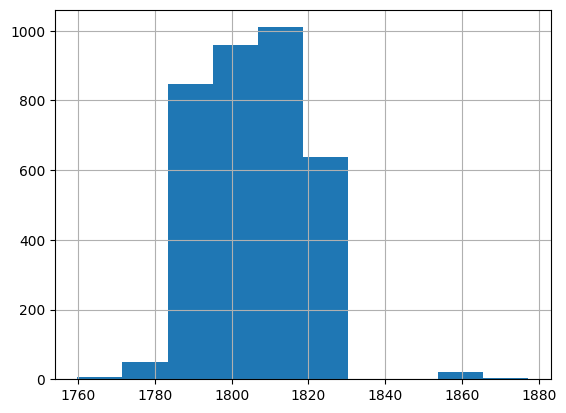

In [9]:
linnean["datetime"].hist()

In [10]:
linnean["18thcent?"] = linnean["datetime"] < pd.to_datetime("1801-01-01")

In [11]:
linnean["sender_agr"] = linnean.apply(lambda row: str(row["sender_surname"]).replace(" ", "_") + "_" + str(row["sender_forename"]).replace(" ", "_"), axis=1)

linnean["recipient_agr"] = linnean.apply(lambda row: str(row["recipient_surname"]).replace(" ", "_") + "_" + str(row["recipient_forename"]).replace(" ", "_"), axis=1)

Nyní se podíváme na osoby, který poslaly a přijaly největší množství dopisů:

In [12]:
linnean["sender_agr"].value_counts()

sender_agr
Smith_Sir_James_Edward       481
Goodenough_Samuel            222
Woodward_Thomas_Jenkinson    101
Roscoe_William                98
Johnes_Thomas                 84
                            ... 
Erskine_David_Steuart          1
Upcher_Abbot                   1
Walcott_William                1
Baker_William_Lloyd            1
Cullen_Charles_Sinclair        1
Name: count, Length: 457, dtype: int64

In [13]:
linnean["recipient_agr"].value_counts()

recipient_agr
Smith_Sir_James_Edward    2948
Macleay_Alexander          102
Smith_Pleasance             72
Roscoe_William              53
Unknown_nan                 51
                          ... 
Sutton_Charles               1
Brandreth_Mrs                1
Bright_Richard               1
Walker_George                1
Reeve_Robert                 1
Name: count, Length: 65, dtype: int64

V obou případech vidíme na prvním místě *Sira Jamese Edwarda Smithe*. Což, víme-li něco o Linneovské společnosti nebo podíváme-li se na wikipedii, není příliš překvapivé: jedná se o samotného zakladatele a dlouholetého předsedu této společnosti (viz [wikipedia](https://en.wikipedia.org/wiki/James_Edward_Smith_(botanist))).

V druhé tabulce vidíme na třetím místě také jeho manželku, *Pleasance Smithovou*, která byla taktéž významnou osobností dobového dění (taktéž viz [wikipedie](https://en.wikipedia.org/wiki/Pleasance_Smith)).  

### Tvorba síťových dat
Pro potřeby následujících si naše data výrazně přeskupíme a přetvoříme do podoby *seznamu vážených vazeb*.

In [14]:
linnean_edges = linnean.groupby(["sender_agr", "recipient_agr"]).size().reset_index()
linnean_edges.columns = ["sender_agr", "recipient_agr", "letters_n"]
linnean_edges.head()

,sender_agr,recipient_agr,letters_n
0,Abbot_Charles,Smith_Sir_James_Edward,18
1,Acharius_Erik,Smith_Sir_James_Edward,8
2,Acrel_Johan_Gustaf,Smith_Sir_James_Edward,7
3,Afzelius_Adam,Smith_Sir_James_Edward,14
4,Aiton_William_Townsend,Smith_Sir_James_Edward,1


Jednotkou pozorování (čili řádkou tabulky) nyní již není každý jednotlivý dopis, ale pár odesilatele a příjemce s informací, kolik odesilatel příjemci zaslal dopisů (viz sloupec `"letters_n"`). Můžeme podívat na tabulku hran setříděnou od těch s největší váhou (tj. s nejvyšším počtem dopisů poslaných daným směrem).

In [15]:
linnean_edges.sort_values("letters_n", ascending=False)

,sender_agr,recipient_agr,letters_n
189,Goodenough_Samuel,Smith_Sir_James_Edward,222
413,Smith_Sir_James_Edward,Macleay_Alexander,102
525,Woodward_Thomas_Jenkinson,Smith_Sir_James_Edward,101
348,Roscoe_William,Smith_Sir_James_Edward,94
241,Johnes_Thomas,Smith_Sir_James_Edward,83
...,...,...,...
352,Rous_Charlotte_Maria,Smith_Sir_James_Edward,1
353,Rowden_Frances_Arabella,Smith_Sir_James_Edward,1
158,Erskine_David_Steuart,Smith_Sir_James_Edward,1
157,Engelhart_John_Henry,Smith_Sir_James_Edward,1


In [16]:
G = nx.from_pandas_edgelist(linnean_edges, 'sender_agr', 'recipient_agr', 'letters_n', create_using=nx.DiGraph())

In [17]:
type(G)

networkx.classes.digraph.DiGraph

Základní vlastnosti, které nás o našem grafu zajímají jsou, kolik má uzlů a kolik má hran?

In [18]:
G.number_of_nodes()

476

In [19]:
G.number_of_edges()

534

Další užitečnou informací je, kolik mají uzle v průměru vazeb (tzv. avarege degree).

In [20]:
sum(dict(G.degree).values()) / G.number_of_nodes()

2.2436974789915967

Stejně tak zajímavé bude se podívat, který uzle mají nejvyšší *in-degree* (tj. vazeb do něj vstupujících) a *out-degree*
(tj. vazeb z něj vystupujících). Podívejme se na deset uzlů s nejvyšší hodnotou in-degree:

In [21]:
sorted(dict(G.in_degree()).items(), key=lambda item: item[1], reverse=True)[:10]

[('Smith_Sir_James_Edward', 445),
 ('Unknown_nan', 14),
 ('Smith_Pleasance', 6),
 ('Cullum_Sir_Thomas_Gery', 4),
 ('Lambert_Aylmer_Bourke', 2),
 ('Wallich_Nathaniel', 2),
 ('Goodenough_Samuel', 2),
 ('The_Linnean_Society_nan', 2),
 ('Banks_Sir_Joseph', 1),
 ('Barrington_Shute', 1)]

Vidíme, že zcela ústřední pozici zde zaujímá *Sir James Edward Smith*, zakladatel a dlouholetý předseda společnosti. Hned na druhém místě se v jednom uzlu potkávají dopisy, jejichž adresát je neznámý. Nebude od věci tento uzel ze sítě zcela odstranit.

In [22]:
G.remove_node("Unknown_nan")

Utvořený síťový graf si můžeme bezprostřdně vizualizovat pomocí funkce `nx.draw()`:

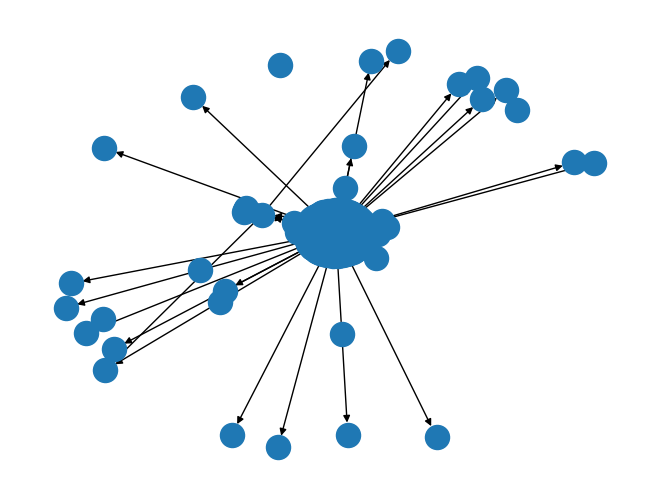

In [23]:
nx.draw(G)

Bohužel vidíme, že výsledek vypadá spíše nevábně. Podle všeho se zde příliš mnoho uzlů poblíž středu. Vidíme, že vazby mají podobu šipek. Je tomu tak proto, že se jedná o tzv. směrový graf.

Abychom dosáhli lepších výsledků, přidáme do vizualizační funkce několik dodatečných parametrů

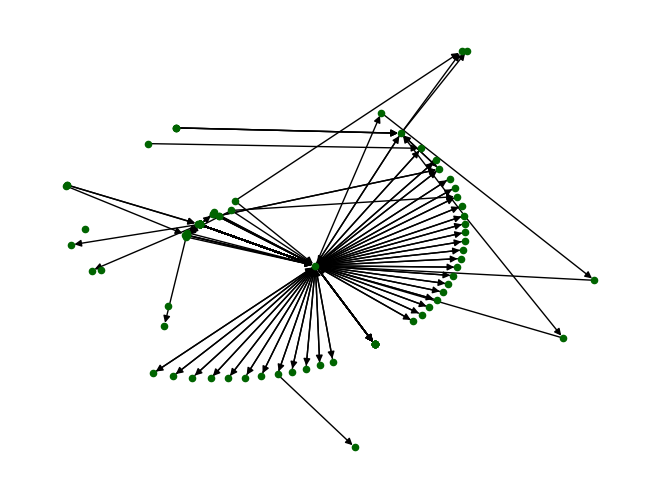

In [24]:
nx.draw(G, node_size=20, node_color="darkgreen", pos=nx.kamada_kawai_layout(G))

Uzly v  grafu se jmenují stejně jako korespondenti. Pomocí syntaxe níže se tak můžeme podívat na vlastnosti jednotlivých vazeb. 

In [25]:
G["Smith_Sir_James_Edward"]["Macleay_Alexander"]

{'letters_n': 102}

In [26]:
G["Macleay_Alexander"]["Smith_Sir_James_Edward"]


{'letters_n': 74}

Zde se dozvídáme, že zatímco Sir James Edward Smith poslal Alexanderu Macleayovi 102, v opačném směru jich šlo 74.

Pro některé typy analýz je praktičtější i smysluplnější pracovat s nesměrovým grafem. Vazba tak nezohledňuje směr příslušné korespondence a váha může odpovídat součtu vyměněných dopisů v obou směrech. Transformovat naši síť do této podoby vyžaduje několik řádek kódy, jimiž se zde nemusíme příliš zaobírat, důležitější je výsledek.

In [27]:
to_remove = []
edges_met = []
for node1, node2 in G.edges():
    if (G.has_edge(node2, node1)) & ((node2, node1) not in edges_met):
        G[node1][node2]["letters_n"] = G[node1][node2]["letters_n"] + G[node2][node1]["letters_n"]
        to_remove.append((node2, node1))
    edges_met.append((node1, node2))

In [28]:
len(edges_met)

519

In [29]:
len(to_remove)

35

In [30]:
for u,v in to_remove:
    G.remove_edge(u,v)

In [31]:
G = G.to_undirected().copy()

In [32]:
len(G.edges())

484

In [33]:
G["Smith_Sir_James_Edward"]["Macleay_Alexander"]

{'letters_n': 176}

In [34]:
G["Macleay_Alexander"]["Smith_Sir_James_Edward"]

{'letters_n': 176}

In [35]:
weighted_degrees = {}
for node in G.nodes():
    weighted_degrees[node] = G.degree(node, weight='letters_n')

In [36]:
weighted_degrees

{'Abbot_Charles': 18,
 'Smith_Sir_James_Edward': 3418,
 'Acharius_Erik': 8,
 'Acrel_Johan_Gustaf': 7,
 'Afzelius_Adam': 14,
 'Aiton_William_Townsend': 1,
 'Allioni_Carlo': 7,
 'Anderson_Alexander': 2,
 'Anderson_James': 2,
 'Anguish_Mrs_S': 1,
 'Annesley_George': 19,
 'Anonymous_nan': 1,
 'Anstruther_Sir_John': 1,
 'Arnott_George_Arnold_Walker': 1,
 'Aufrere_Anthony': 1,
 'Babington_William': 2,
 'Backhouse_James': 2,
 'Bagg_C_J': 1,
 'Baillie_Matthew': 8,
 'Bainbridge_J_H': 1,
 'Baker_J': 1,
 'Baker_John': 2,
 'Baker_Richard': 2,
 'Baker_William_Lloyd': 1,
 'Balbis_Giovanni_Battista': 1,
 'Baldwin_John': 2,
 'Baldwin_William': 2,
 'Banfather_Henry': 1,
 'Banks_Sir_Joseph': 52,
 'Barclay_Robert': 3,
 'Barker_Edmund_Henry': 5,
 'Barnwell_Frederick_Henry_Turnor': 1,
 'Barrington_Jane': 13,
 'Lambert_Aylmer_Bourke': 81,
 'Barrington_Shute': 8,
 'Bateman_James': 1,
 'Beadon_Richard': 1,
 'Sutton_Charles': 3,
 'Beattie_James': 3,
 'Beeke_Henry': 3,
 'Bellardi_Carlo_Antonio_Ludovico': 12,
 '

In [37]:
# tento degree učiníme atributem našich uzlů
nx.set_node_attributes(G, weighted_degrees, 'weighted_degree')

Nyní si vyjmeme pouze uzly, které mají stupeň alespoň roven 2, tj. uzly osob, kteří v našem datasetu vedly korespondenci s více než jednou osobou.

In [38]:
node_list = [node for node in G.nodes if G.degree(node) >= 2]
len(node_list)

28

Ukazuje se, že takových uzlů je v našem datasetu relativně málo. Vypišme si jejich jména.

In [39]:
node_list

['Smith_Sir_James_Edward',
 'Barrington_Jane',
 'Lambert_Aylmer_Bourke',
 'Sutton_Charles',
 'Bicheno_James_Ebenezer',
 'Forster_Edward',
 'Boyd_George',
 'Roxburgh_William',
 'Brodie_James',
 'Coke_Thomas_William',
 'Wallich_Nathaniel',
 'Crowe_James',
 'Cullum_Sir_Thomas_Gery',
 'Smith_Pleasance',
 'Davy_Martin',
 'Don_George',
 'Goodenough_Samuel',
 'Drake_William_Fitt',
 'Gemmellaro_Carlo',
 'The_Linnean_Society_nan',
 'Gurney_Anna',
 'Harriman_John',
 'Johnes_Thomas',
 'Latham_John',
 'Martyn_Thomas',
 'Smith_James',
 'Swartz_Olof_Peter',
 'Webb_William']

Nyní tento seznam jmen využijeme k vymezení výseku z našeho grafu (nazveme si jej `Gsub`), který bude zahrnovat pouze tyto uzly. 

In [40]:
Gsub = G.subgraph(node_list)

(-1.3, 1.3)

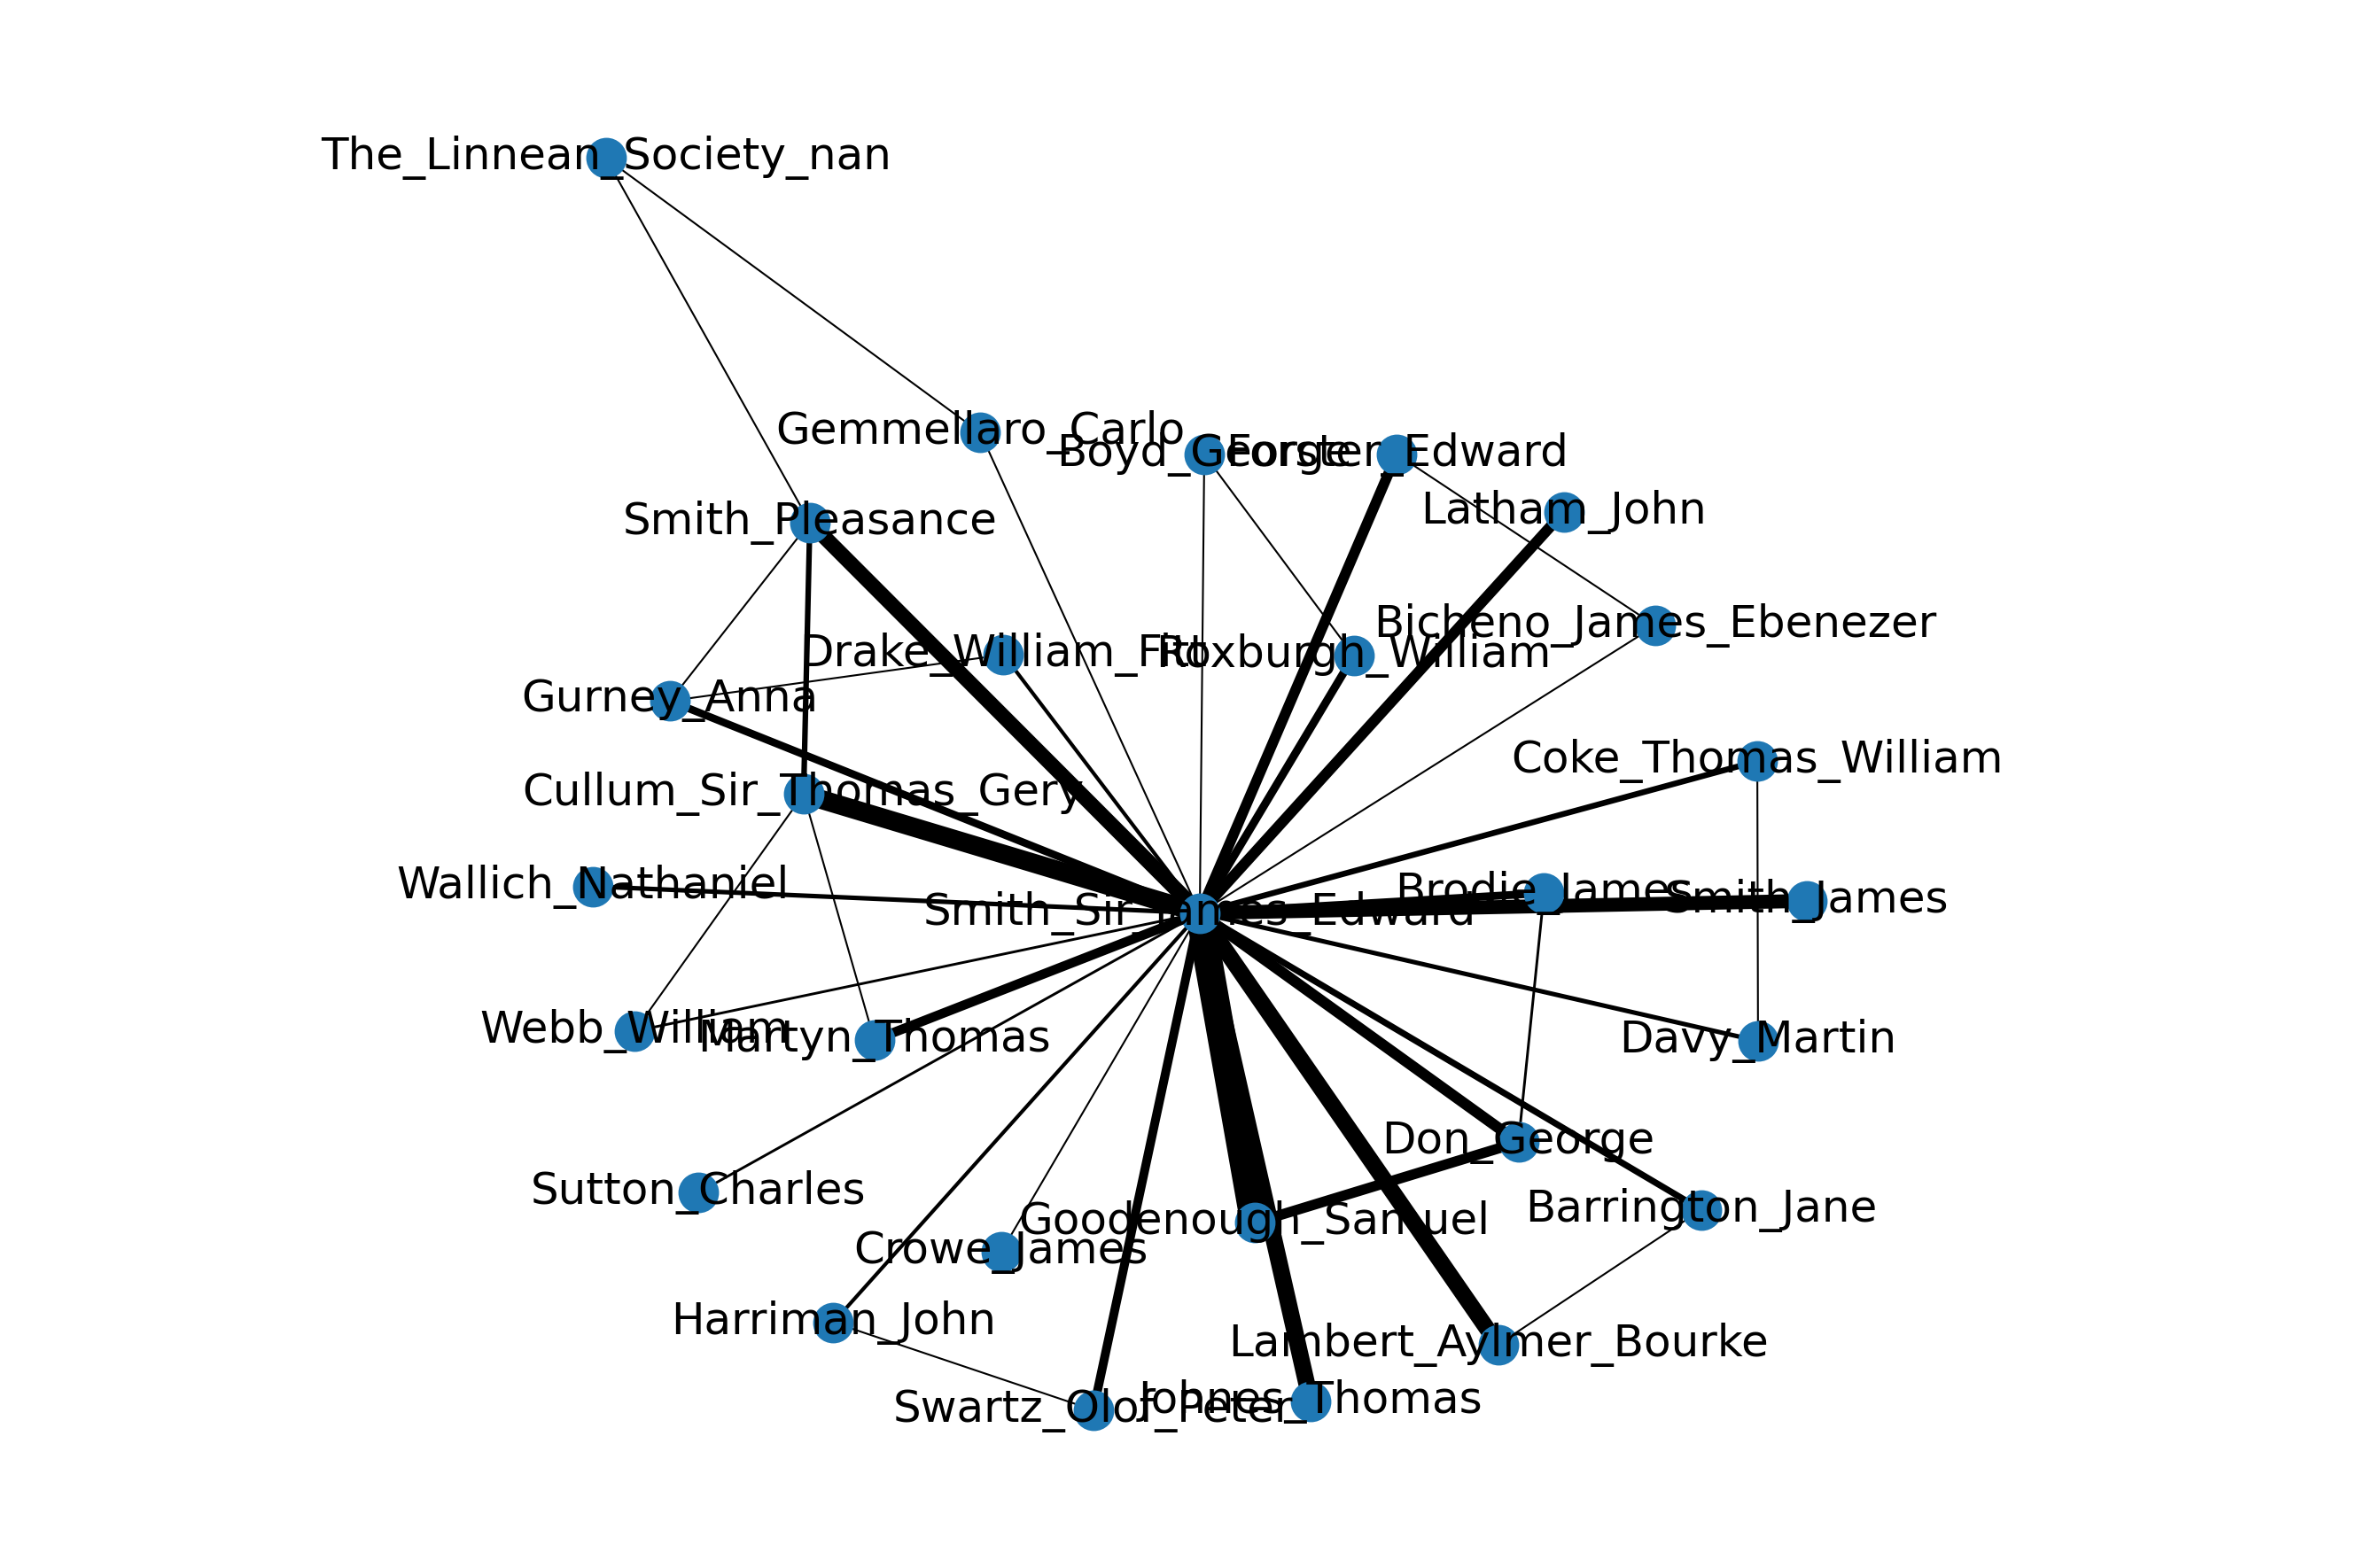

In [41]:
fig, ax = plt.subplots(1,1, figsize=(9, 6), dpi=300, tight_layout=True)

# pro potřeby vizualizace si ještě definujeme šířku čar jednotlivých vazeb,vycházející z objemu vyměněných dopisů. 
edge_widths = [np.sqrt(d['letters_n']) / 2 for (u, v, d) in Gsub.edges(data=True)]


nx.draw(Gsub, with_labels=True, pos=nx.kamada_kawai_layout(Gsub), node_size=100, nodelist=node_list, width=edge_widths, ax=ax)

ax.set_xlim(-1.3, 1.3)

Z takovéto vizualizace již lze vypozorovat leccos.

In [42]:
len(G)

475

# Britská vědecká korespondence dlouhého 19. století jako celek

Nyní se vrátíme na začátek. Projekt Ɛpsilon totiž hostí vícero kolekcí dopisů z podobného období a je na místě očekávat, že se osoby v těchto kolekcích budou alespoň částečně překrývat.

Vypišme si tedy nejprve jména csv souborů s metadaty k těmto kolekcím.

In [43]:
resp_json = requests.get("https://github.com/cambridge-collection/epsilon-data/tree/main/csv").json()
filenames = [item["name"] for item in resp_json["payload"]["tree"]["items"]]
filenames

['ampere.csv',
 'darwin-correspondence.csv',
 'darwin-family-letters.csv',
 'faraday.csv',
 'henslow.csv',
 'herschel.csv',
 'kemp.csv',
 'linnean-society.csv',
 'royal-society.csv',
 'somerville.csv',
 'tyndall.csv']

Nyní pomocí cyklu FOR načteme data ze všech těchto souborů a nakonec je spojíme do jednoho objektu type `pd.DataFrame`.

In [44]:
dfs = [] # připrav prázdný seznam, který budeme následně postupně plnit daty z jednotlivých kolekcí 
for filename in filenames: # pro každý z našeho seznamu souborů:
    try: # zkus: jej načíst jako dataframe
        collection_df = pd.read_csv("https://raw.githubusercontent.com/cambridge-collection/epsilon-data/main/csv/" + filename)
        collection_df["source"] = filename # přidej tomuto dataframu nový sloupec "source", kde bude uvedeno jméno souboru, ze kterého pochází
        dfs.append(collection_df) # přidej do seznamu aktuální dataframe
    except: # pokud to nejde:
        print("failed: ", filename) # vypiš jméno souboru, u kterého to nejde
epsilon = pd.concat(dfs) # spoj do jednoho všechny dataframy uvnitř seznamu dfs

failed:  darwin-family-letters.csv


In [45]:
epsilon.head(5)

,id,sender_surname,sender_forename,recipient_surname,recipient_forename,sorting_date,date,sender_address,recipient_address,source,languages,extent,filename
0,L1,Ampère,Jeanne-Antoinette (mère d'Ampère),Ampère,André-Marie,1775-01-01,s.d.,NaN,NaN,ampere.csv,fra,NaN,L1.xml
1,L2,Maine de Biran,Pierre,Ampère,André-Marie,1807-03-15,15 mars 1807,NaN,NaN,ampere.csv,fra,NaN,L2.xml
2,L3,Ampère,André-Marie,Ampère,Jean-Jacques (fils d'Ampère),1775-01-01,s.d.,NaN,NaN,ampere.csv,fra,NaN,L3.xml
3,L4,Ampère,André-Marie,Duhamel,Jean-Marie,1775-01-01,s.d.,NaN,NaN,ampere.csv,fra,NaN,L4.xml
4,L5,Ampère,André-Marie,Duhamel,Jean-Marie,1775-01-01,s.d.,NaN,NaN,ampere.csv,fra,NaN,L5.xml


In [46]:
# jak dlouhý je náš dataset?
len(epsilon)

47459

In [113]:
# stejně jako výše agregujme jména autorů a příjemců dopisů do podoby bez mezer a závorek
epsilon["sender_agr"] = epsilon.apply( lambda row: str(row["sender_surname"]).replace(" ", "_").partition(" (")[0] + "_" + str(row["sender_forename"]).replace(" ", "_").partition(" (")[0], axis=1)
epsilon["sender_agr"] = epsilon["sender_agr"].apply(lambda x: regex.sub("[^\p{L}_-]", "", x))

epsilon["recipient_agr"] = epsilon.apply( lambda row: str(row["recipient_surname"]).replace(" ", "_").partition(" (")[0] + "_" + str(row["recipient_forename"]).replace(" ", "_").partition(" (")[0], axis=1)
epsilon["recipient_agr"] = epsilon["recipient_agr"].apply(lambda x: regex.sub("[^\p{L}_-]", "", x))

Vypišme si nejplodnější autory a nejpopulárnější příjemce:

In [114]:
epsilon["sender_agr"].value_counts()

sender_agr
Darwin_C_R             8151
Herschel_Sir_John      5353
Faraday_Michael        2985
Tyndall_John           1146
Airy_George_Biddell     751
                       ... 
Bunbury_E_H               1
Jacob_Edward              1
Smirke_E                  1
Copley_J_S                1
Bohn_Johann_C             1
Name: count, Length: 5763, dtype: int64

In [115]:
epsilon["recipient_agr"].value_counts()

recipient_agr
Herschel_Sir_John                           9305
Darwin_C_R                                  6713
Smith_Sir_James_Edward                      2948
Faraday_Michael                             2102
Tyndall_John                                1291
                                            ... 
Humboldt_Friedrich_Wilhelm_Alexander_von       1
Plummer_Isabella_Erskine                       1
Magendie_François                              1
Ayres_Philip_Burnard                           1
Clausius_Adelheid                              1
Name: count, Length: 3945, dtype: int64

Tentokrát si data vazeb do nesměrové podoby převedeme ještě před vytvořením grafu.

In [117]:
epsilon_temp = epsilon.apply(lambda row: pd.Series(sorted([str(row["sender_agr"]), str(row["recipient_agr"])])), axis=1)
epsilon_temp.columns = ["node1", "node2"]
epsilon_edges = epsilon_temp.groupby(["node1", "node2"]).size().reset_index()
epsilon_edges.columns = ["node1", "node2", "weight"]
epsilon_edges = epsilon_edges[epsilon_edges["node1"] != epsilon_edges["node2"]]
epsilon_edges.head(5)

,node1,node2,weight
0,AB_Hewetson_nan,Tristram_Henry_Baker,1
1,AB_nan,Faraday_Michael,2
2,AT_TO_LOOK,Unknown_nan,1
3,AW_Williamson_Foreign_Secretary_Royal_Society,Williamson_Alexander_William,1
4,A_B,Royal_Society_nan,1


Data v této podobě můžeme již neprodleně použít k tvorbě sítě váženého nesměrového grafu.

In [118]:
G = nx.from_pandas_edgelist(epsilon_edges, 'node1', 'node2', 'weight')

Opět se nejprve podíváme, z kolika uzlů a kolika hran naše síť sestává:

In [119]:
G.number_of_nodes()

7646

In [120]:
G.number_of_edges()

9088

Z těchto dat lze také snadno vypočítat tzv. *average degree*:

In [121]:
(2 * G.number_of_edges()) / G.number_of_nodes()

2.377190687941407

U grafu s takto velkým počtem uzlů se nezřídka stane, že se ukáže, že je ve skutečnosti tvořen několika oddělenými komponenty, čili že síť není zcela propojená.

In [122]:
len(list(nx.connected_components(G)))

166

Ano, to je i náš případ zde, když máme co dočinění s grafem, který sestává z více než 160 komponentů.

Podívejme se, z kolika uzlů sestává deset největších komponentů:

In [123]:
components_sorted = sorted(list(nx.connected_components(G)), key=len, reverse=True)
[len(comp) for comp in components_sorted][:10]

[7295, 5, 4, 4, 3, 3, 3, 3, 3, 3]

Vidíme, že většina uzlů je součástí největšího komponentu, druhý největší komponent sestává již pouue z 5 uzlů. S klidným svědomím se nyní zaměříme pouze na největší komponent naší sítě.

In [124]:
len(components_sorted[0])

7295

In [125]:
G = G.subgraph(list(components_sorted[0]))#.copy()

In [126]:
G.number_of_nodes() #zkontrolujeme, že se filtrace uzlů povedla

7295

In [127]:
%%time
pos = nx.spring_layout(G)

CPU times: user 51.8 s, sys: 130 ms, total: 52 s
Wall time: 53.9 s


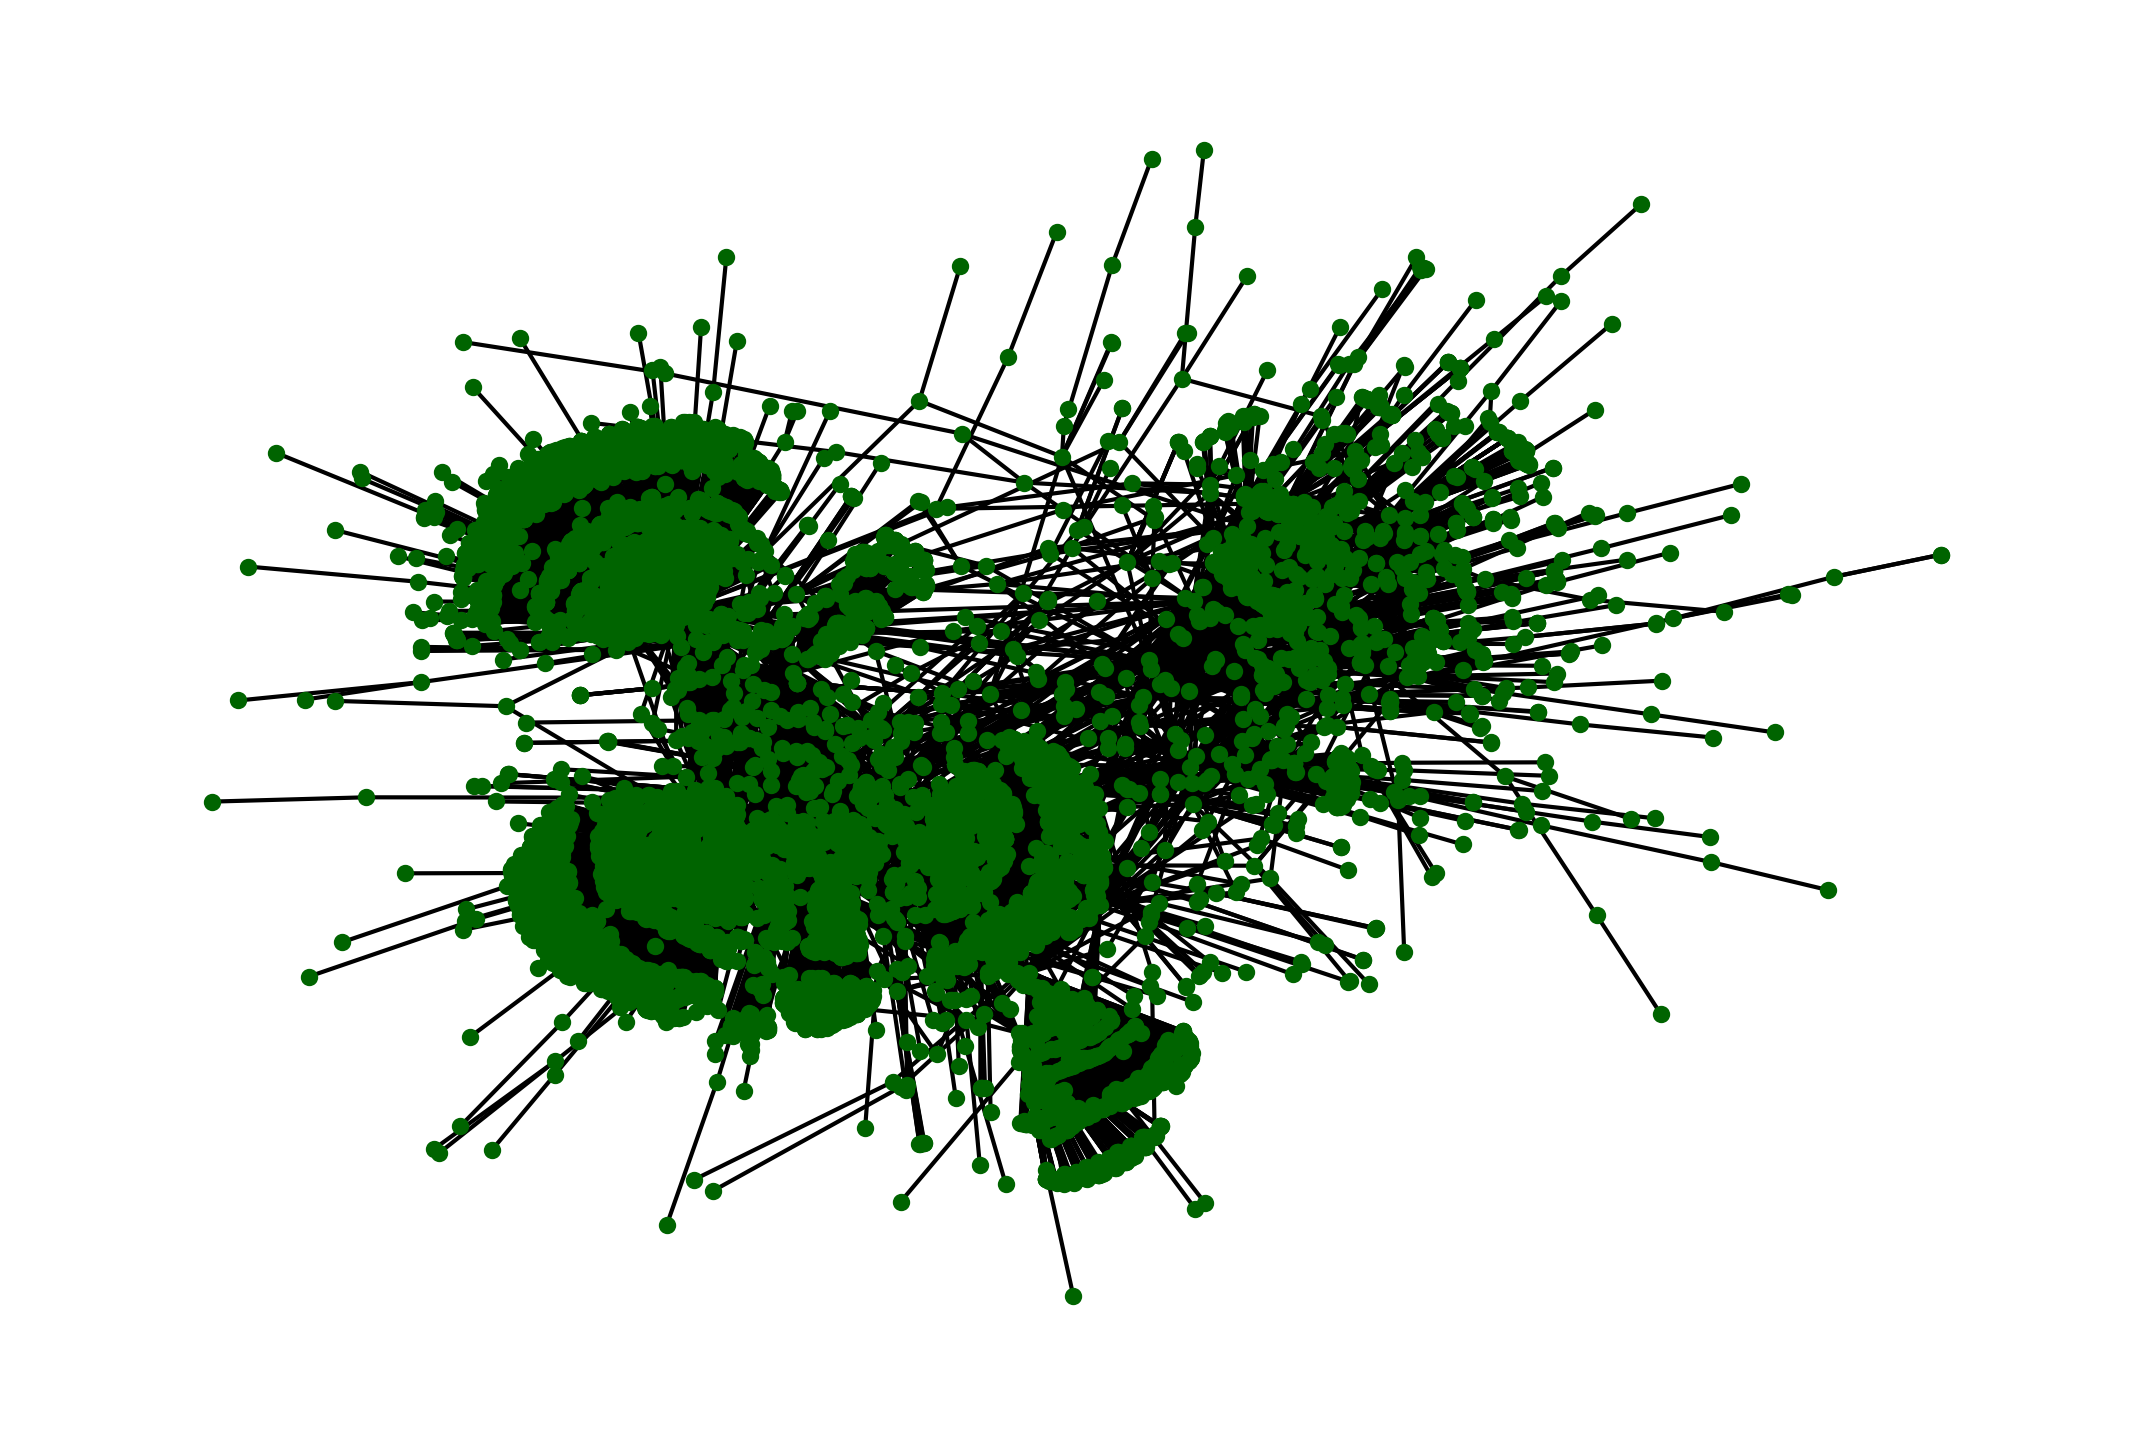

In [128]:
fig, ax = plt.subplots(figsize=(9,6), dpi=300)
nx.draw(G, node_size=10, node_color="darkgreen", pos=pos, ax=ax)

Tato síť již možná má některé zajímavé topografické vlastnosti, které si zaslouží bližší analytické ohledání.

Jedna skupina populárních a užitečných algoritmů jsou tzv. *metriky centrality* uzlů či vazeb. Uveďme si dvě takové metriky s jejich anglickými názvy a krátkým vysvětlením  nejznámnější s jejich anglickými názvy:
* **degree centrality**: je definován počtem vazeb spojující daný uzel
* **closeness centrality**: součet vzdáleností nejkratších cest potřebných k dosažení všech ostatních uzlů uvnitř sítě.
* **betweenness centrality** (mezilehlost): Jak často se ten který uzel nachází na trase spojující nejkratší cestou jakékoli další uzly uvnitř sítě.  
* **PageRank centrality**: je určen mnohonásobně opakovanými náhodnými procházkami po síti. Velikost PageRank je určena množstvím návštěv daného uzlu při těchto procházkách. Tento algoritmus byl původně vyvinut vývojáři od společnosti pro určení důležitých webových stránek.

S degree centrality jsme již vlastně  pracovali, když jsme se u předchozí sítě omezili pouze na uzly s degree alespoň 2. Tato metrika je také nejsnáze srozumitelná a bude zajímavé si zde představit její výsledky pro potřeby srovnání s výsledky ostatních metrik.
Jelikož zde však pracujeme s relativně rozsáhlou sítí a náš společný čas je omezený, vyzkoušíme si nyní pouze algrotimus pro PageRank, který je výpočetně nejméně náročný.

In [138]:
degree_centrality = nx.degree_centrality(G)
degree_top_nodes = sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)
degree_top_nodes[:10]

[('Darwin_C_R', 0.27337537702221004),
 ('Herschel_Sir_John', 0.24362489717576088),
 ('Faraday_Michael', 0.1616397038661914),
 ('Smith_Sir_James_Edward', 0.06292843432958596),
 ('Tyndall_John', 0.0527831094049904),
 ('Henslow_J_S', 0.04154099259665478),
 ('Royal_Society_nan', 0.029064984919111598),
 ('nan_nan', 0.027282698108034),
 ('Ampère_André-Marie', 0.02604880723882643),
 ('Banks_Joseph', 0.01946805593638607)]

In [139]:
pagerank_centrality = nx.pagerank(G)
pagerank_top_nodes = sorted(pagerank_centrality.items(), key=lambda x:x[1], reverse=True)
pagerank_top_nodes[:10]

[('Darwin_C_R', 0.12531743230350081),
 ('Herschel_Sir_John', 0.11578752463912399),
 ('Faraday_Michael', 0.057520944520063226),
 ('Smith_Sir_James_Edward', 0.028529193763289443),
 ('Tyndall_John', 0.022548106020346178),
 ('Henslow_J_S', 0.01330130754811916),
 ('Ampère_André-Marie', 0.011978899884381007),
 ('Hooker_J_D', 0.010425398525256518),
 ('Royal_Society_nan', 0.009683475973305872),
 ('nan_nan', 0.009509369237027814)]

In [141]:
degree_pagerank_comparison = []
for deg, pag in zip(degree_top_nodes, pagerank_top_nodes):
    degree_pagerank_comparison.append([deg[0], deg[1], pag[0], pag[1]])
degree_pagerank_comparison_df = pd.DataFrame(degree_pagerank_comparison)
degree_pagerank_comparison_df.columns = ["degree_node", "degree_val", "pagerank_node", "pagerank_val"]
degree_pagerank_comparison_df.head(20)

,degree_node,degree_val,pagerank_node,pagerank_val
0,Darwin_C_R,0.273375,Darwin_C_R,0.125317
1,Herschel_Sir_John,0.243625,Herschel_Sir_John,0.115788
2,Faraday_Michael,0.161640,Faraday_Michael,0.057521
3,Smith_Sir_James_Edward,0.062928,Smith_Sir_James_Edward,0.028529
4,Tyndall_John,0.052783,Tyndall_John,0.022548
5,Henslow_J_S,0.041541,Henslow_J_S,0.013301
6,Royal_Society_nan,0.029065,Ampère_André-Marie,0.011979
7,nan_nan,0.027283,Hooker_J_D,0.010425
8,Ampère_André-Marie,0.026049,Royal_Society_nan,0.009683
9,Banks_Joseph,0.019468,nan_nan,0.009509


V čem je toto srovnání potenciálně zajímavé? Podíváme-li se na pravou stranu tabulky, tj. uzly s největší PageRank centralitou, vidíme, že zejména ve druhé desítce se nachází nemálo uzlů, se kterými se na levé straně v první dvacítce vůbec nesetkáváme:
* Hooker_J_D
* Airy_George_Biddell
* Babbage_Charles
* Hirst_Thomas_Archer
* De_Morgan_Augustus
Jinými slovy, jedná se o uzly, jejichž centralita v rámci sítě není živena výlučně množstvím vazeb, které uvnitř sítě mají, ale spíše specifickým strukturálním postavením.

Podívejme se, na kolikáté pozici se tyto uzly nacházejí z hlediska degree centrality (v tabulce výše jsme si povšimli, že se nenacházejí mezi dvacítkou uzlů s nejvyšší hodnotou této metriky).

In [146]:
pagerank_nodes = ["Hooker_J_D", "Airy_George_Biddell", "Babbage_Charles", "Hirst_Thomas_Archer", "De_Morgan_Augustus"]
for node in pagerank_nodes:
    print(node, " - degree position: ", [el[0] + 1 for el in enumerate(degree_top_nodes) if el[1][0] == node][0])
    

Hooker_J_D  - degree position:  51
Airy_George_Biddell  - degree position:  28
Babbage_Charles  - degree position:  64
Hirst_Thomas_Archer  - degree position:  1156
De_Morgan_Augustus  - degree position:  4226


In [130]:
from networkx.algorithms import community
comp = community.girvan_newman(G)
first_communities = tuple(sorted(c) for c in next(comp))


KeyboardInterrupt: 